In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
%load_ext autoreload
%autoreload 2

from __future__ import division

import autoutils, scipy, auto, os, json, misc, sympy
from sympyutils import rmap, mapsubs, jac
from sympy import lambdify, S
from scipy import eye, dot, diag
import numpy
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.integrate


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:

class ContinuationTool_2D(object):
    def __init__(self, simfile, foldername=False, sim_label=""):
        self.simfile = simfile
        self.workdir= "./data/"
        if (foldername): self.foldername = "./"+foldername+simfile[:6]+"/"
        else: self.foldername = "./data/"
        self.sim_label = sim_label
        #--------------------------------------------
        nak = json.load(open(self.workdir+simfile+'.json'))
        self.nak = nak
        #--------------------------------------------
        self.FP_continuation = False
        self.runList = []
        self.bifpar = {}
        #-----------------------------
        self.resolution = 20
        self.additionalInfo = False
        #--------------------------------
        self.continuationParams = ['I', 'gNa']
        self.forwardIntegrationTime = 1000
        self.rheobaseDict = {'izhikevich_temperature': 4.5128676303,  # 23.1413, # at V1=-18
                          'wangBuzsaki': 0.16008632717,    # first LP at 0.16
                          }
        self.plottingBranches = []
        self.stopDictList = False
        
    def set_parameter(self, key, value):
        self.nak['par'][key] = value
        self.bifpar.update({key:value})   # this updates self.bifpar to the new value
        return self.nak['par']
        
    def set_continuationParams(self, continuationParamList=[]):
        if (len(continuationParamList)>0): self.continuationParams = list(continuationParamList)    # this ensures that the continuationParamList is not changed in the fuction that calls this function, it creates a local copy.
        if ('I' not in self.continuationParams): self.continuationParams.append('I')
        self.bifpar = dict([(k,self.nak['par'][k]) for k in self.continuationParams])  # key value pairs as found in the parameters in the model.
        self.bifpar.update({'dotZF':.1,  # initiation of the normalization for Z which is demanded to be 1 later on.
                            'lam':0,    # we are searching for the case lambda=0, which is the periodic solution which does not decay.
                            'dummy':1,
                            'dummy2':1,
                            'dummy3':1,
                            'dummy4':1,
                            'dummy5':1,
                            'dummy6':1,
                            'dummy7':1,
                            'dummy8':1,
                            'dummy9':1})
        return self.bifpar
    
    def set_spikecriterion(self):
        V_dot = self.fill_in_fcts_and_par( S(self.nak['ode'][0]) )
        self.spikecriterion = str( V_dot.subs(dict([(k,k+'_left') for k in self.nak['var']])) )   # string with the equations with all non-bifpar parameters inserted, in which all variables (v and gating variables) are replaced by the same parameter with a postfix of "_left"
        return self.spikecriterion
    
    def fill_in_other_params(self, term):
        par = self.nak['par'].copy()
        for parameter in self.bifpar: 
            if (parameter in par): par.pop(parameter)
        replacement = par
        import sympyutils
        try:
            return sympyutils.mapsubs(term, replacement)   # if the term is a vector this does the job
        except:
            return term.subs(replacement)      # otherwise the term is just a single equation (a string), then this does the job

    def fill_in_bifpar(self, term):
        replacement = self.bifpar
        import sympyutils
        try:
            return sympyutils.mapsubs(term, replacement)   # if the term is a vector this does the job
        except:
            return term.subs(replacement)      # otherwise the term is just a single equation (a string), then this does the job

    
    def fill_in_fcts(self, term):
        replacement = self.nak['fun']
        import sympyutils
        try:
            return sympyutils.mapsubs(term, replacement)   # if the term is a vector this does the job
        except:
            return term.subs(replacement)      # otherwise the term is just a single equation (a string), then this does the job
    
    def fill_in_fcts_and_par(self, term, bifparAsWell=False):
        term = self.fill_in_fcts(term)
        if (bifparAsWell): term = self.fill_in_bifpar(term)
        return self.fill_in_other_params(term)
    
    
    def init_FP_continuation(self, I=0):
        # fix point continuation, without caring about the PRC, with the ability to find Hopf bifurcations
        self.set_parameter('I', I)
        print "Using I = ", I
        self.set_continuationParams()   # this also initializes self.bifpar with the values from the self.nak['par'], i.e. mostly from the simfile
        self.set_spikecriterion()
        self.unames, self.pnames= autoutils.writeFP('nak',
            bifpar=self.bifpar,
            rhs=self.fill_in_fcts_and_par(S(self.nak['ode'])),
            var=self.nak['var'],
            bc=['{0}_left-{0}_right'.format(v) for v in self.nak['var']]+[self.spikecriterion], # boundary conditions
            ic=[]) # integral conditions (e.g. constant energy)

    def init_forward_integration(self, tmax=300, dt=0.01):
        ''' Initiation values for the orbit (one spiking voltage trace) and period. '''
        # tmax=300 seems to be good for the Izhikevich or Morris Lecar model, but the Destexhe Pare model requires longer time, tmax=1000, for relaxation.
        t = numpy.linspace(0,tmax, int(tmax/dt))
        init = numpy.ones(len(self.nak['var'])) * 0.01
        for i, var in enumerate(self.nak['var']):
            if var in ['h', 's']: init[i] = 0.95 # initialize h and s with one as they are inactivating gating variables
        # The following is only needed if the resting state is very sensitive to the initial conditions, which is not the case in most models.
        #if (len(self.nak['var'])>=4):init_forward_integration
        #    init[3] = 0.9    # some gating variables should be large
        print "Forward integration with I=", self.bifpar['I']
        ode = self.fill_in_fcts_and_par( S(self.nak['ode']), bifparAsWell=True )
        ode_lambdified = sympy.lambdify(S(self.nak['var']), ode)
        equationSystem = lambda x,t: ode_lambdified(*x)    # this ensures that the function that is returned takes two parameters: the first is one array with the two variables, the second is a parameter for the time, which is ignored as no explicit time dependence is given. This is needed for scipy.integrate.odeint.
                                                           # equation system also depends on the time in an explicit way: the fuction accepts a second parameter, the time, although there is no explicit dependence of the result on t.
        return equationSystem,init,t

    def get_fixpoint_initiation(self, tmax=300, dt=0.01):
        equationSystem,init,t = self.init_forward_integration(tmax, dt)
        init[0]= -70
        y= scipy.integrate.odeint(equationSystem,init,t)  # this gives me the relaxation to the resting potential, thus the resting potential with which I can start auto is y[-1]
        plt.subplot(121); plt.plot(t, y[:,0]); plt.subplot(122); plt.plot(t, y[:,1:]); plt.legend(self.nak['var'][1:], loc='best')
        return y[-1]  # relaxed dynamics, returns the resting state, the state after tmax ms.
    
    def continue_fixPoint(self, I = 0.1, UZSTOP_criterium = {'I':200}, direction = 1, tmax=300):
        numberOfIterations = 5000
        numberOfPlots = 1
        dsmax = 1e0
        self.init_FP_continuation(I)   # start continuation at I =3 to prevent problems that may arise at I=0.
        restingstate = self.get_fixpoint_initiation(tmax)
        print "restingstate = ", restingstate, self.simfile
        r1= auto.run(restingstate, e='nak', c='nak',
                parnames= self.pnames, unames=self.unames,
                ICP=self.continuationParams, 
                ISP=1,ILP=1, #SP=['LP','HB','BP'],   # ISP: Bifurcation detection; 0=off, 1=BP(FP), 3=BP(PO,BVP), 2=all | ILP: Fold detection; 1=on, 0=off
                ISW=1, # ISW: Branch switching; 1=normal, -1=switch branch (BP, HB, PD), 2=switch to two-parameter continuation (LP, BP, HB, TR), 3=switch to three-parameter continuation (BP)
                PAR=self.bifpar, ITNW=17, NWTN=13, NMX=numberOfIterations, NPR=int(numberOfIterations/numberOfPlots),
                DS=direction*1e-1, DSMAX=dsmax, #STOP=[''],#STOP=['HB1'],
                UZSTOP= UZSTOP_criterium   # e.g. UZSTOP_criterium={'gNa':15, 'gK':1, 'gK':12, 'V3':-10, 'V3':30, 'V1':-10, 'V1':30}
                )
        self.FP_continuation = r1
        self.r_eval = [r1]
        return r1
    
    def init_continuation_2D(self, params, UZSTOP_criterium = {'gL':1, 'Cm':0.1, 'I':0, 'gL':10, 'Cm':2, 'I':100}):
        # this sets the startValues for the following locus continuation of the interesting points, requires then two parameters for continuation
        self.set_continuationParams(params)
        r1 = self.continue_fixPoint(UZSTOP_criterium = UZSTOP_criterium)
        self.fixpointContinuation = r1
        h1=auto.plot(r1, stability=True, hide=True, bifurcation_y='v', xlabel_fontsize=14, ylabel_fontsize=14, grid=True)
        h1.savefig(self.foldername+'bifurcationDiagram{0}.svg'.format("_vVSinput"))
        self.r_eval = r1
        return r1
    
    
    def twoDimension_Hopf(self, startState, continuationParams, stopDictList = [{'gL':10, 'Cm':50, 'I':400}, {'gL':0.1, 'Cm':10, 'I':0.1}]):
        global relevantHopf
        # locus continuation of the interesting points, requires then two parameters for continuation
        self.bifpar['I'] = startState['I']
        numberOfIterations = 2000
        numberOfPlots = 1
        directionList = [1, -1]
        r = [0 for item in directionList]
        direction = 1
        r[0] = auto.run(startState, e='nak', c='nak',
                parnames= self.pnames, unames=self.unames,
                ICP=continuationParams, 
                ISP=2,ILP=1, #SP=['LP','HB','BP'],   # ISP: Bifurcation detection; 0=off, 1=BP(FP), 3=BP(PO,BVP), 2=all | ILP: Fold detection; 1=on, 0=off
                ISW=2, # ISW: Branch switching; 1=normal, -1=switch branch (BP, HB, PD), 2=switch to two-parameter continuation (LP, BP, HB, TR), 3=switch to three-parameter continuation (BP)
                PAR=self.bifpar, ITNW=17, NWTN=13, NMX=numberOfIterations, NPR=int(numberOfIterations/numberOfPlots),
                DS=direction*1e-1, DSMAX=1e-1, #STOP=[''],#STOP=['HB1'],
                UZSTOP= {}#stopDictList[i]   # e.g. UZSTOP_criterium={'gNa':15, 'gK':1, 'gK':12, 'V3':-10, 'V3':30, 'V1':-10, 'V1':30}
                )
        if True:
            print "Limit direction in twoDimension_Hopf"  # this can give trouble when running into the BT, then it does not stop
            direction = -1
            numberOfIterations =2000
            numberOfPlots = 1
            DSMAX = 1.5e-1   # adapt this, smaller to find GH, larger to prevent that the continuation gets into an infinite loop at the BT
            #if self.get_parameter('gL')>=0.2: DSMAX = 5e-1   # adapt this, smaller to find GH, larger to prevent that the continuation gets into an infinite loop at the BT
            r[1] = auto.run(startState, e='nak', c='nak',
                    parnames= self.pnames, unames=self.unames,
                    ICP=continuationParams, 
                    ISP=2,ILP=1, #SP=['LP','HB','BP'],   # ISP: Bifurcation detection; 0=off, 1=BP(FP), 3=BP(PO,BVP), 2=all | ILP: Fold detection; 1=on, 0=off
                    ISW=2, # ISW: Branch switching; 1=normal, -1=switch branch (BP, HB, PD), 2=switch to two-parameter continuation (LP, BP, HB, TR), 3=switch to three-parameter continuation (BP)
                    PAR=self.bifpar, ITNW=7, NWTN=3, NMX=numberOfIterations, NPR=int(numberOfIterations/numberOfPlots),
                    DS=direction*1e-1, DSMAX=DSMAX, #STOP=[''],#STOP=['HB1'],
                    UZSTOP= {}#stopDictList[i]   # e.g. UZSTOP_criterium={'gNa':15, 'gK':1, 'gK':12, 'V3':-10, 'V3':30, 'V1':-10, 'V1':30}
                    #UZSTOP= {'Cm':0.08}continue_hopf
                    )
            relevantHopf = r[1].getLabel(r[1].getLabels()[-1])[-1]
            #relevantHopf = r1.getLabel('UZ')[0]
            self.plottingBranches.append(auto.merge(r[0]+r[1]))
            self.r_eval = r
        else:
            self.plottingBranches.append(r[0])
            self.r_eval = [r[0]]
        self.params = continuationParams
        return self.plottingBranches[-1]
    
    def continue_hopf(self, startState, continuationParams, stopDictList = [{'gL':10, 'Cm':50, 'I':400}, {'gL':0.1, 'Cm':10, 'I':0.1}]):
        # takes a BT point and restarts a continuation a bit above both parameter values in the hope to find Hopf bifurcations which allow to continue the Hopf branch arising from the BT
        orgValues = dict([(param, self.get_parameter(param)) for param in continuationParams])
        for param in continuationParams: 
            self.set_parameter(param, 1.01*startState[param])   # adapt the percentage change to the model situation!
        searchSpikeOnsetState = self.init_continuation_2D(self.continuationParams, stopDictList[0])
        if (len(searchSpikeOnsetState.getLabel('HB'))<=1):
            print "--- ATTENTION: NOT ENOUGH HB, trying to decrease parameters"
            for param in continuationParams: 
                self.set_parameter(param, 0.9*startState[param])   # adapt the percentage change to the model situation!
            searchSpikeOnsetState = self.init_continuation_2D(self.continuationParams, stopDictList[0])            
        lastRun = False
        for i in range(len(searchSpikeOnsetState.getLabel('HB'))):   # this runs into an error for gL=0.1 and wangBuzsaki_kirst
        #for i in []:
            print "--- Evaluating HB nearby BT"
            lastRun = self.twoDimension_Hopf(searchSpikeOnsetState.getLabel('HB')[i], continuationParams, stopDictList)
            if (continueGH and len(lastRun.getLabel('GH'))>0):
                continuationTool.continue_GH(lastRun.getLabel('GH')[0], continuationParams, stopDictList)
        for param in continuationParams: 
            self.set_parameter(param, orgValues[param])
        return lastRun
    
    def plot_branches(self):
        r = self.plottingBranches[0]
        for i in range(1, len(self.plottingBranches)):
            r += self.plottingBranches[i]
        h1=auto.plot(r, stability=True, hide=True, bifurcation_y=self.params[1], xlabel_fontsize=14, ylabel_fontsize=14,
                     grid=True, use_labels=False, decorations=True)     #  Does not do anything: label=["RUN 1", "RUN 2", "RUN 3"], indices=[1,2,3])
        h1.config(minx=self.stopDictList[1][self.params[0]], miny=self.stopDictList[1][self.params[1]], maxx=self.stopDictList[0][self.params[0]], maxy=self.stopDictList[0][self.params[1]])
        #h1.config(minx=39, maxx=40, miny=0, maxy=10)
        #h1.config(minx=-4, maxx=4, miny=-0.1, maxy=14)   # simfile = 'wangBuzsaki_kirst'
        h1.config(minx=-10, maxx=70, miny=-0.5, maxy=5)   # simfile = 'wangBuzsaki' for continuation of Cm
        h1.config(minx=-1, maxx=10, miny=-0.1, maxy=1)   # simfile = 'wangBuzsaki' for continuation of gL
        figPath = self.foldername+'bifurcationDiagram{0}.svg'.format(self.sim_label)
        h1.savefig(figPath)
        print "--- Plot saved as ", figPath


Using I =  0.1
initvar {1: 0, 2: 0, 3: 0}
initpar {1: 0, 2: 0.1, 3: 1, 4: 1, 5: 0.1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 0.1, 11: 0, 12: 1, 13: 1, 14: 1, 15: 1}
<type 'numpy.int64'> <type 'numpy.int64'>
For fix point continuation AUTO requires:
14=4+0-3+1 (ICP=NBC+NINT-NDIM+1)

Forward integration with I= 0.1
restingstate =  [-62.30521834   0.73465691   0.10144907] wangBuzsaki
gcc -g -O2 -I/extra/jhs/auto/07p/include -O -c nak.c -o nak.o
gfortran -L/extra/jhs/auto/07p/lib -fopenmp -O nak.o -o nak.exe /extra/jhs/auto/07p/lib/*.o -lauto_c
Starting nak ...

  BR    PT  TY  LAB       I          L2-NORM          v             h             n             Cm            gL      
   1     8  LP    2   1.60086E-01   5.99696E+01  -5.99658E+01   6.62778E-01   1.20506E-01   1.00000E+00   1.00000E-01
   1    29  LP    3  -6.57900E+00   4.11153E+01  -4.11135E+01   1.24157E-01   3.62684E-01   1.00000E+00   1.00000E-01
   1    65  HB    4   2.51294E+01   2.93198E+01  -2.93147E+01   3.44734E-02   5.46257E-01   

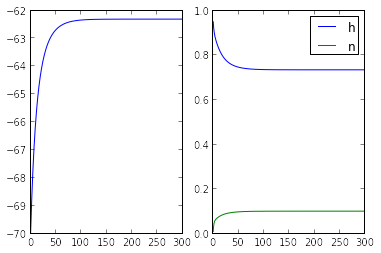

In [30]:
foldername = "data/"
simfile = 'wangBuzsaki'; stopDictList = [{'gL':10, 'Cm':5, 'I':100}, {'gL':0.01, 'Cm':-0.5, 'I':-40}]
#simfile = 'izhikevich_temperature'; stopDictList = [{'gL':10, 'Cm':5, 'I':100}, {'gL':0.01, 'Cm':-0.5, 'I':-40}]
continuationTool = ContinuationTool_2D(simfile, foldername, sim_label="20170213")
continuationParams = ['I', 'Cm', 'gL']
continuationTool.stopDictList = stopDictList

startState = continuationTool.init_continuation_2D(continuationParams, stopDictList[0])
print "Continuing with label", startState.getLabels()[2]
lastRun = continuationTool.twoDimension_Hopf(startState.getLabel(startState.getLabels()[2]), continuationParams, stopDictList)